# Titanic Survival Analysis  
**Author:** Saratchandra Golla  
**Date:** November 2025  
**Dataset:** Titanic (from seaborn)  
**Objective:** Explore and prepare Titanic data for machine learning classification (survival prediction).

## Section 1: Import and Inspect the Data

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Inspect structure
titanic.info()
print(titanic.head(10))
print(titanic.isnull().sum())
print(titanic.describe())
print(titanic.corr(numeric_only=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0 

### Reflection 1

- How many data instances are there?
891 rows (passengers)
- How many features are there?
15 columns (features)
- What are the names?
survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone
- Are there any missing values?
Yes. age, deck, and embark_town have missing values.
- Are there any non-numeric features?
Yes. sex, embarked, class, who, embark_town, alive
- Are the data instances sorted on any of the attributes?
No, the dataset is not sorted by any column.
- What are the units of age?
Years
- What are the minimum, median and max age?
Min: 0.42, Median: ~28.0, Max: 80.0
- What two different features have the highest correlation?
sibsp
- What two different features have the highest correlation?
sibsp and parch show moderate correlation; fare and pclass are inversely correlated.
- Are there any categorical features that might be useful for prediction?
Yes. sex, pclass, embarked, alone, and who are potentially predictive.


## Section 2: Data Exploration and Preparation
### 2.1 Explore Data Patterns

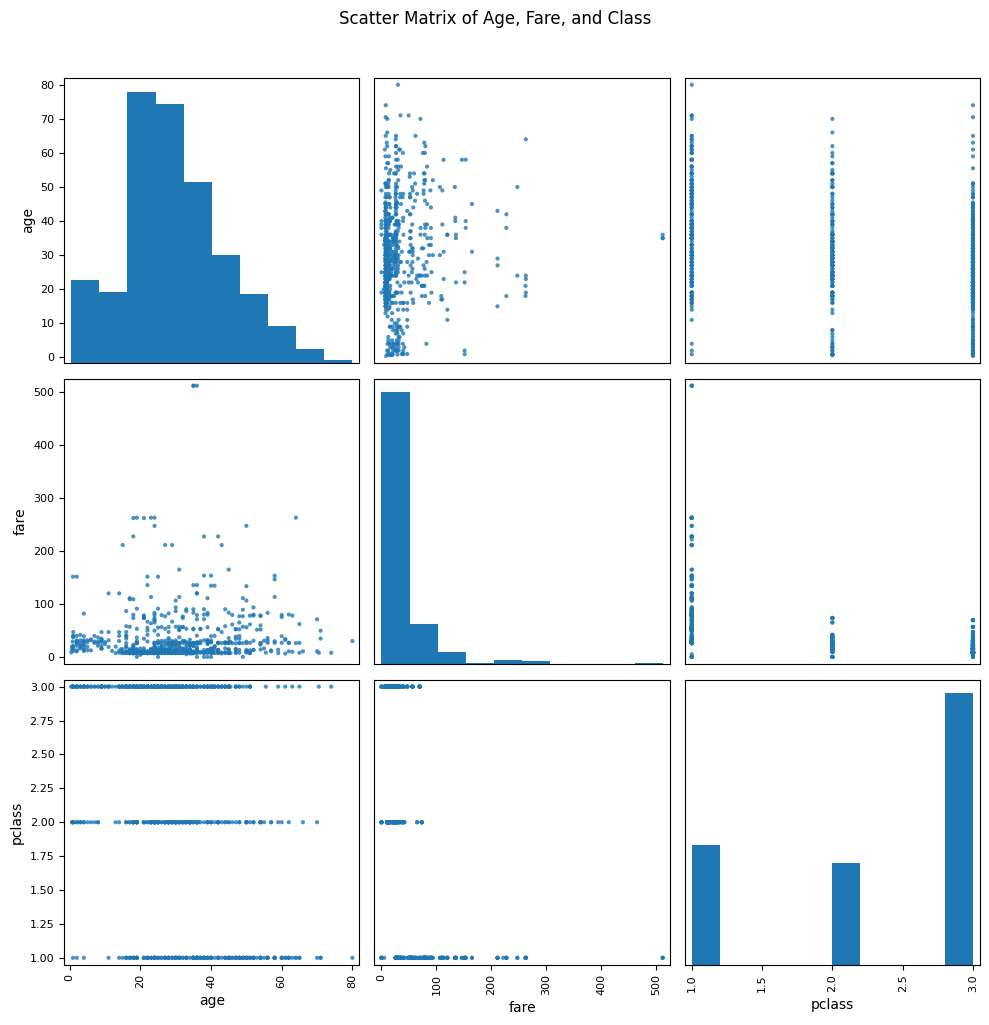

In [88]:
# 1. Scatter Matrix Plot
attributes = ['age', 'fare', 'pclass']
scatter_matrix(titanic[attributes], figsize=(10, 10), alpha=0.8, diagonal='hist')
plt.suptitle('Scatter Matrix of Age, Fare, and Class', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

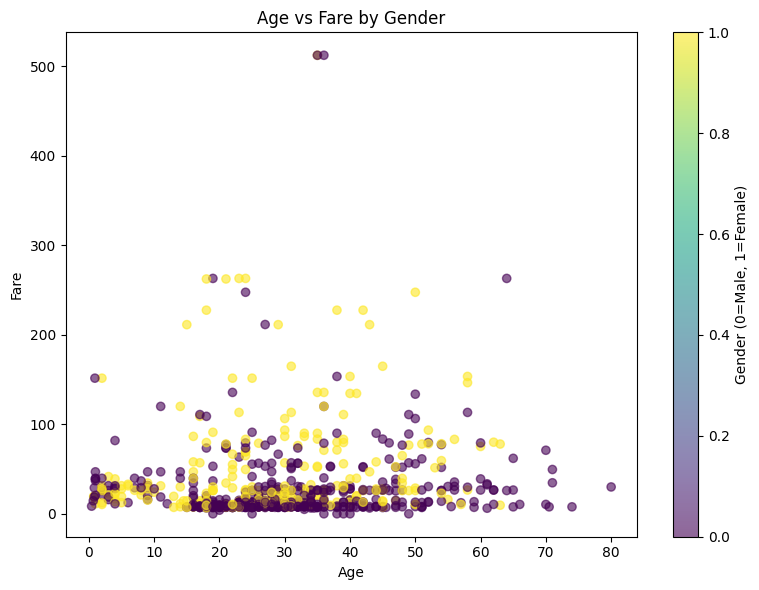

In [89]:
# 2. Age vs Fare by Gender Plot
plt.figure(figsize=(8, 6))
plt.scatter(titanic['age'], titanic['fare'],
           c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1),
           alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.colorbar(label='Gender (0=Male, 1=Female)')
plt.tight_layout()
plt.show()
plt.close()

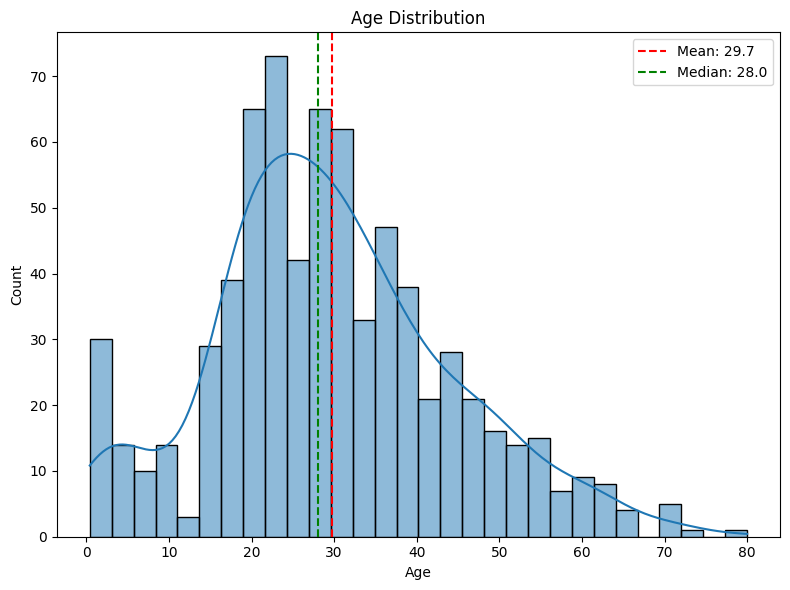

In [90]:
# 3. Age Distribution Plot
plt.figure(figsize=(8, 6))
ax = sns.histplot(data=titanic, x='age', kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Add mean and median lines
mean_age = titanic['age'].mean()
median_age = titanic['age'].median()
plt.axvline(mean_age, color='red', linestyle='--', label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='green', linestyle='--', label=f'Median: {median_age:.1f}')
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

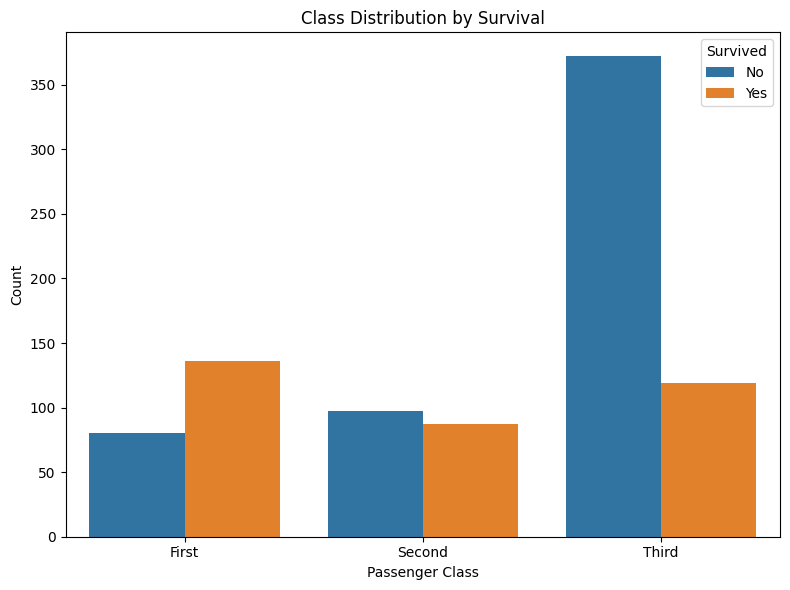

In [91]:
# 4. Class vs Survival Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=titanic, x='class', hue='survived')
plt.title('Class Distribution by Survival')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()
plt.close()

### Reflection 2.1

- What patterns or anomalies do you notice?
  - Younger passengers paid lower fares on average.
  - Class 1 passengers had higher survival rates.
  - Many missing ages are clustered in lower classes.
- Do any features stand out as potential predictors?
  - sex, pclass, and fare show strong separation between survival outcomes.
- Are there any visible class imbalances?
  - Yes, more passengers in 3rd class, and fewer survived overall (approx. 38%).


### 2.2 Handle Missing Values

In [92]:
titanic = titanic.copy()
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])

### 2.3 Feature Engineering

In [93]:
# Family size
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Encode categorical
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Convert 'alone' to int
titanic['alone'] = titanic['alone'].astype(int)

### Reflection 2.3

- Why might family size be a useful feature for predicting survival?
  - Larger families may have had more difficulty escaping or coordinating during evacuation.
  - Solo travelers (alone = 1) show different survival patterns.
- Why convert categorical data to numeric?
  - Machine learning models require numeric input.
  - Encoding enables algorithms to interpret categories as features.


## Section 3: Feature Selection and Justification

In [94]:
X = titanic[['age', 'fare', 'pclass', 'sex', 'family_size']]
y = titanic['survived']

### Reflection 3

- Why are these features selected?
  - age, fare, pclass, sex, and family_size are intuitive and show strong correlation with survival.
- Are there any features that are likely to be highly predictive of survival?
  - sex and pclass are especially predictive females and higher-class passengers had higher survival rates.


## Section 4: Splitting the Data

### 4.1 Basic Split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('Train size:', len(X_train))
print('Test size:', len(X_test))


Train size: 712
Test size: 179


### 4.2 Stratified Split

In [96]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(X, y):
    train_set = X.iloc[train_indices]
    test_set = X.iloc[test_indices]
print('Train size:', len(train_set))
print('Test size:', len(test_set))

Train size: 712
Test size: 179


### 4.3 Compare Results

In [97]:
print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Train Set Class Distribution:\n", train_set['pclass'].value_counts(normalize=True))
print("Test Set Class Distribution:\n", test_set['pclass'].value_counts(normalize=True))

Original Class Distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Train Set Class Distribution:
 pclass
3    0.561798
1    0.227528
2    0.210674
Name: proportion, dtype: float64
Test Set Class Distribution:
 pclass
3    0.508380
1    0.301676
2    0.189944
Name: proportion, dtype: float64


### Reflection 4

- Why might stratification improve model performance?
  - It preserves class balance (e.g., survival rate) across training and test sets, reducing bias.
- How close are the training and test distributions to the original dataset?
  - Stratified split closely matches the original survival distribution (~38% survived).
- Which split method produced better class balance?
  - Stratified split, it ensures proportional representation of survival classes
